## first import 

In [1]:
import torch
import triton
import random
from copy import deepcopy
import os
import time
from flash_nsa.utils import NSAHelper
os.environ['TRITON_PRINT_AUTOTUNING'] = '1'
import flash_attn
print(torch.__version__)
print(triton.__version__)
print(flash_attn.__version__)
def compare(x, y, prefix=""):
    if x is None or y is None:
        return
    assert x.shape == y.shape
    if 0 in list(x.shape):
        return
    
    if any([x.dtype == torch.float32, y.dtype==torch.float32]):
        x,y = x.float(), y.float()
    diff = (x-y).abs()
    if prefix:
        print(prefix, end=": ")
    print(f"max_diff: {diff.max().item()}, mean_diff: {diff.mean().item()}")

def generate_cu_seqlens(end=8192, mean=2048, std=512):
    r = [0]
    while r[-1] < end:
        a = random.randint(mean-std, mean+std)
        r.append(r[-1] + a)
    r[-1] = end
    cu_seqlens = torch.tensor(r, device=torch.cuda.current_device(), dtype=torch.int32)
    return cu_seqlens

def set_seed(seed=0):
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    
import matplotlib.pyplot as plt
from matplotlib.image import imread
import os

def display_image(image_path):
    img = imread(image_path)
    # 显示图片
    plt.figure(figsize=(8, 6))  # 设置画布大小
    plt.imshow(img)
    plt.axis('off')  # 关闭坐标轴
    plt.title(f"Image: {os.path.basename(image_path)}", fontsize=12)  # 显示文件名
    plt.tight_layout()  # 优化布局
    plt.show()

kernel_size = 32
stride = 16
block_size = 64
NSAHelper.set_hyperparameters(kernel_size=kernel_size, stride=stride, block_size=block_size, top_n=24)


/home/hadoop-aipnlp/miniforge3/envs/mdy/lib/python3.12/site-packages/torch/cuda/__init__.py:63: FutureWarning: The pynvml package is deprecated. Please install nvidia-ml-py instead. If you did not install pynvml directly, please report this to the maintainers of the package that installed pynvml for you.
  import pynvml  # type: ignore[import]


2.8.0+cu126
3.4.0
2.8.3


# NSAHelper

Q: What is `NSAHelper`?

A: `NSAHelper` is a global Class that store many key attrs for `NSA`.

Q: Why use `NSAHelper`?

A: `NSA` is a complicated algorithm. It contain many hyperparameters and sequence infos, especially open the `context parallel`. \
And many kernels use the same attrs. So it's a good way that use a global Class to get these attrs.

<!-- ![](./imgs/nsahelper.png) -->

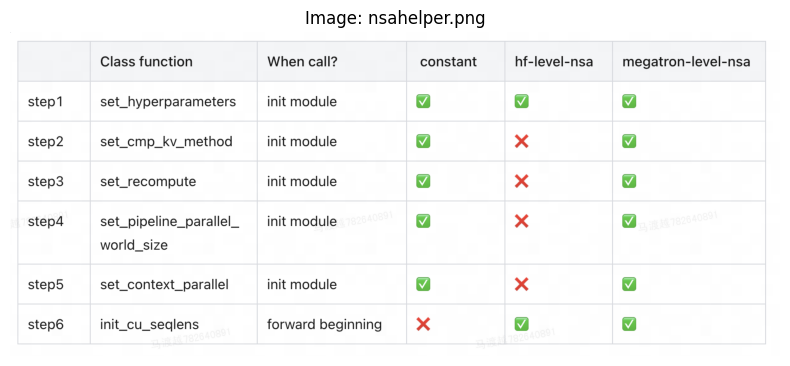

In [2]:
display_image("./imgs/nsahelper.png")

In [3]:
from flash_nsa.config import NSAConfig
# any config is ok.
config = NSAConfig()

# step1: set basic hyperparameters. For megatron level nsa and huggingface level nsa.
# This class function is only called at the module init stage. 
# These attributes are static and will not change during a training task.
NSAHelper.set_hyperparameters(kernel_size=config.kernel_size, 
                              stride=config.stride, 
                              block_size=config.block_size, 
                              top_n=config.top_n,
                              num_init_blocks=config.num_init_blocks,
                              num_local_blocks=config.num_local_blocks,
                              window_size=config.window_size
                              )

# step2: set compress kv methohs. Only for megatron level nsa
# This class function is only called at the module init stage. 
# These attributes are static and will not change during a training task.
# I provide 4 compressing methohs. They are mean, linear, swiglu and sigmoid-mul.
# Because all ops are in just one Function. So we need know which method we use in Function.
# Maybe you can del this function and use nsa function args replaced
NSAHelper.set_cmp_kv_method(cmp_k_method="mean", cmp_v_method="linear")

# step3: set recompute. Only for megatron level nsa.
# This class function is only called at the module init stage. 
# These attributes are static and will not change during a training task.
# If all set True, the activation memory equals to flash-attn‘s. Only save the final attn-output
NSAHelper.set_recompute(recompute_cmp_kv=config.recompute_cmp_kv,
                        recompute_cmp_o=config.recompute_cmp_o,
                        recompute_slc_o=config.recompute_slc_o,
                        recompute_swa_o=config.recompute_swa_o)

# step4: set pipeline paralle size. Only for megatron level nsa
# This class function is only called at the module init stage. 
# These attributes are static and will not change during a training task.
# for 1f1b (and others) pp schedule, the sequence infos may change in one training step interleaved.
# The sequence infos are initiated at forward beginning, so we need save these infos for backward.
# Or we will get wrong attrs from global Class.
pp_size = 1 # please get the true pp_size in training.
NSAHelper.set_pipeline_parallel_world_size(pp_size=pp_size)

# step5: set basic context parallel attrs.  Only for megatron level nsa
# This class function is only called at the module init stage.
# If cp_world_size <= 1, it's will not init cp infos
# please get the true cp group in training.
process_group = None
# kv_head_stride: computing attn output in a loop, each iteration only use `nsa_kv_head_stride` kv_heads 
    # and nsa_kv_head_stride * qh//kh  q_heads. It will save memory, because we should all-gather kv in each iteration beginning.
# use_overlap_swa: spilt swa into 2 stages. Use first stage to overlap the kv all-gather. 
    # The effect is not obvious. setting True or False is all ok.
# These attributes are static and will not change during a training task.
NSAHelper.set_context_parallel(process_group=process_group, kv_head_stride=config.kv_head_stride, use_overlap_swa=config.use_overlap_swa)


In [4]:
# step6: set cu_seqlens. For megatron level nsa and huggingface level nsa.
# This class function is called at the forward beginning. 
# These attributes are dynamic and will change according to different merged docs.

kwargs = {"cu_seqlens": torch.tensor([0, 1024, 2500, 4096], device="cuda", dtype=torch.int32)}
# must provide
cu_seqlens = kwargs.get("cu_seqlens", None)
assert cu_seqlens is not None

# Default None. cu_seqlens_np = cu_seqlens.cpu().numpy(), it's effect when init cp, beacuse there are many cpu op. 
cu_seqlens_np = kwargs.get("cu_seqlens_np", None)

# this attr can be constant and can also be dynamic. choices in [1, 2]
# For example, this is a sequence [0, 1, 2, 3, 4, 5, 6, 7] and cp = 4. Each rank get two token.
# if cp_mode = 1, rank0: [0,1], rank1: [2,3], rank2: [4,5], rank3: [6,7]
# if cp_mode = 2, rank0: [0,7], rank1: [1,6], rank2: [2,5], rank3: [3,4]
# if cu_seqlens is [0, 2048, 4096, 6144， 8192], so cp_mode=1 is good and compute balance
# if cu_seqlens is [0, 8192], so cp_mode=2 is more good and compute balance
# So we can write a function to comfirm the cp-mode according to the cu_seqlens or fix it based on prior knowledge
cp_mode = kwargs.get("cp_mode", config.cp_mode)
NSAHelper.init_cu_seqlens(x_cu_seqlens=cu_seqlens, x_cu_seqlens_np=cu_seqlens_np, cp_mode=cp_mode)

# compress_kv

## construct_blocks
<!-- ![](./imgs/construct_block.png) -->

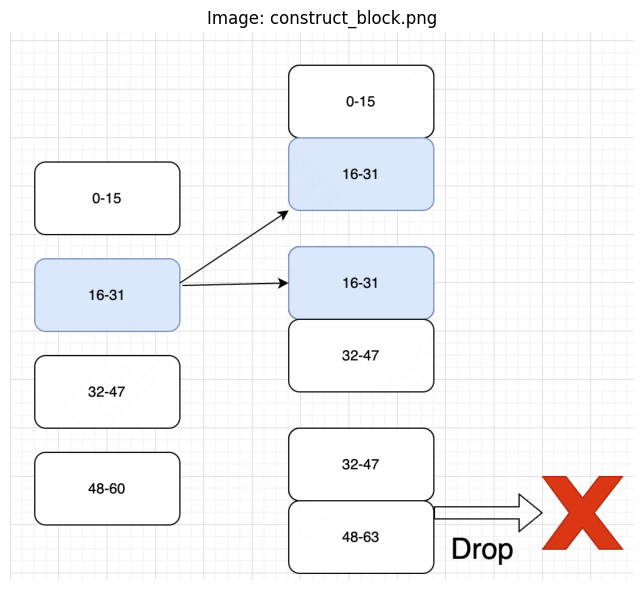

In [5]:
display_image("./imgs/construct_block.png")

In [4]:
from flash_nsa.ops.compress_kv import construct_block
from flash_nsa.ops.torch_ref import torch_construct_block

dtype = torch.bfloat16
device = "cuda"
t, h, d = 8192 * 4, 4, 192
x_cu_seqlens = generate_cu_seqlens(end=t, mean=t//4, std=512)
b = len(x_cu_seqlens) - 1


NSAHelper.init_cu_seqlens(x_cu_seqlens)
x1 = torch.randn(t, h, d, device=device, dtype=dtype)
x1.requires_grad_(True)
x2 = deepcopy(x1)

# if bs=1, y1.size(0) = num_blocks = (T - kerner_size) // stride + 1
# if T < 32, num_blocks = 0
# if T = 32, num_blocks = 1
# if T = 47, num_blocks = 1
# if T = 48, num_blocks = 2
# y1.shape = [total_num_blocks, h, kernel_size, d]
y1 = construct_block(x1)
dy = torch.randn_like(y1)

def func():
    y2_list = []
    for idx in range(b):
        y2 = torch_construct_block(x2[x_cu_seqlens[idx]:x_cu_seqlens[idx+1]], kernel_size, stride)
        y2_list.append(y2)
    y2 = torch.cat(y2_list, 0)
    return y2
y2 = func()
y1.backward(dy, retain_graph=True)
y2.backward(dy, retain_graph=True)
compare(y1, y2)
compare(x1.grad, x2.grad)
print(triton.testing.do_bench(lambda: construct_block(x1)))
print(triton.testing.do_bench(lambda: func()))
print(triton.testing.do_bench(lambda: y1.backward(dy, retain_graph=True), grad_to_none=[x1]))
print(triton.testing.do_bench(lambda: y2.backward(dy, retain_graph=True), grad_to_none=[x2]))


max_diff: 0.0, mean_diff: 0.0
max_diff: 0.0, mean_diff: 0.0
0.04426172159899353
0.6791649169392056
0.04379835302996285
0.7680328436065138


## mean_pooling
one step compress function

In [2]:
from flash_nsa.ops.compress_kv import construct_block, mean_pooling
from flash_nsa.ops.torch_ref import torch_construct_block

dtype = torch.bfloat16
device = "cuda"
t, h, d = 8192, 4, 128
x_cu_seqlens = generate_cu_seqlens(end=t, mean=t, std=0)
b = len(x_cu_seqlens) - 1

NSAHelper.init_cu_seqlens(x_cu_seqlens)

x1 = torch.randn(t, h, d, device=device, dtype=dtype)
x1.requires_grad_(True)
x2 = deepcopy(x1)

# tow_step: construct_block -> mean
y1 = construct_block(x1).mean(-2)
dy = torch.randn_like(y1)

# one_step, one kernel, x -> compress_x
y2 = mean_pooling(x2)
y1.backward(dy, retain_graph=True)
y2.backward(dy, retain_graph=True)
compare(y1, y2)
compare(x1.grad, x2.grad)
print(triton.testing.do_bench(lambda: construct_block(x1).mean(-2)))
print(triton.testing.do_bench(lambda: mean_pooling(x2)))
print(triton.testing.do_bench(lambda: y1.backward(dy, retain_graph=True), grad_to_none=[x1]))
print(triton.testing.do_bench(lambda: y2.backward(dy, retain_graph=True), grad_to_none=[x2]))


max_diff: 0.0, mean_diff: 0.0
max_diff: 0.0, mean_diff: 0.0
0.016801157049666355
0.010767383786574665
0.07626700006719482
0.060744982469848725


# cmp_attn

In [9]:
from flash_nsa.ops.compress_attn import compress_attn
from flash_nsa.ops.torch_ref import torch_cmp_attn
device = "cuda"
dtype = torch.bfloat16

qh, kh, d, vd =  64, 4, 192, 128
t = 8192
x_cu_seqlens = generate_cu_seqlens(end=t, mean=t, std=0)
# t = 1024
# x_cu_seqlens = generate_cu_seqlens(end=t, mean=4, std=0)
b = len(x_cu_seqlens) - 1
NSAHelper.init_cu_seqlens(x_cu_seqlens)
y_cu_seqlens = NSAHelper.y_cu_seqlens
print(x_cu_seqlens, y_cu_seqlens)
NSAHelper.use_tma = True
q1 = torch.randn(x_cu_seqlens[-1], qh, d, device=device, dtype=dtype).requires_grad_(True)
k1 = torch.randn(y_cu_seqlens[-1], kh, d, device=device, dtype=dtype).requires_grad_(True)
v1 = torch.randn(y_cu_seqlens[-1], kh, vd, device=device, dtype=dtype).requires_grad_(True)
q2, k2, v2 = deepcopy(q1), deepcopy(k1), deepcopy(v1)
torch.cuda.empty_cache()

# kv_len = num_blocks
# mask score
# k_idx = block_idx * stride + kernel_size - 1 
# q_idx >= k_idx
# the output fisrt kernel_size - 1 tokens' value is 0
y1, lse = compress_attn(q1, k1, v1)

def func():
    y2_list = []
    for idx in range(b):
        y2 = torch_cmp_attn(q2[x_cu_seqlens[idx]:x_cu_seqlens[idx+1]], 
                            k2[y_cu_seqlens[idx]:y_cu_seqlens[idx+1]], 
                            v2[y_cu_seqlens[idx]:y_cu_seqlens[idx+1]], 
                            kernel_size, 
                            stride)
        y2_list.append(y2)
    y2 = torch.cat(y2_list, 0)
    return y2
y2 = func()
dy = torch.randn_like(y1)
y1.backward(dy, retain_graph=True)
y2.backward(dy, retain_graph=True)

compare(y1, y2)
compare(q1.grad, q2.grad)
compare(k1.grad, k2.grad)
compare(v1.grad, v2.grad)
print(triton.testing.do_bench(lambda: compress_attn(q1, k1, v1)))
print(triton.testing.do_bench(lambda: func()))
print(triton.testing.do_bench(lambda: y1.backward(dy, retain_graph=True), grad_to_none=[q1, k1, v1]))
print(triton.testing.do_bench(lambda: y2.backward(dy, retain_graph=True), grad_to_none=[q2, k2, v2]))

tensor([   0, 8192], device='cuda:0', dtype=torch.int32) tensor([  0, 511], device='cuda:0', dtype=torch.int32)
max_diff: 0.0234375, mean_diff: 0.0004596710205078125
max_diff: 0.03125, mean_diff: 0.0003757476806640625
max_diff: 0.140625, mean_diff: 0.0057373046875
max_diff: 0.5, mean_diff: 0.006988525390625
0.4056641521907988
4.885689640045166
1.4597993220313121
7.546687960624695


In [11]:
from flash_nsa.ops.compress_attn import compress_attn
device = "cuda"
dtype = torch.bfloat16

qh, kh, d, vd = 64, 4, 128, 128
t = 8192 * 8
x_cu_seqlens = generate_cu_seqlens(end=t, mean=t, std=0)
b = len(x_cu_seqlens) - 1
NSAHelper.init_cu_seqlens(x_cu_seqlens)
y_cu_seqlens = NSAHelper.y_cu_seqlens


q1 = torch.randn(t, qh, d, device=device, dtype=dtype).requires_grad_(True)
k1 = torch.randn(y_cu_seqlens[-1], kh, d, device=device, dtype=dtype).requires_grad_(True)
v1 = torch.randn(y_cu_seqlens[-1], kh, vd, device=device, dtype=dtype).requires_grad_(True)
torch.cuda.empty_cache()

y1, lse = compress_attn(q1, k1, v1)

dy = torch.randn_like(y1)
y1.backward(dy, retain_graph=True)


print(triton.testing.do_bench(lambda: compress_attn(q1, k1, v1)))
print(triton.testing.do_bench(lambda: y1.backward(dy, retain_graph=True), grad_to_none=[q1, k1, v1]))

9.005768775939941
32.00718879699707


# topk

## general topk
- it only writes the `cmp_atn_prob` to the global memory
- many options for block_size, kernel_size and stride that satisfy:
    - `stride` is power of 2
    - `kernel_size` % `stride` = 0
    - `block_size` % `stride` = 0
    - `block_size` >= `kernel_size`

<!-- ![](./imgs/general_topk.png) -->



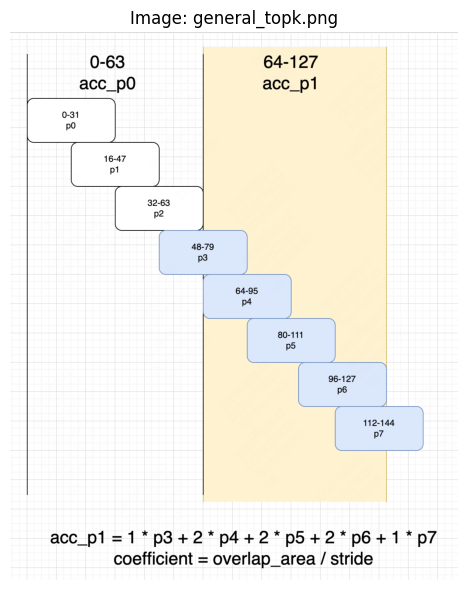

In [6]:
display_image("./imgs/general_topk.png")

In [5]:
from flash_nsa.ops.compress_attn import compress_attn
from flash_nsa.ops.topk import slc_topk_indices
from flash_nsa.ops.torch_ref import torch_topk
device = "cuda"
dtype = torch.bfloat16

qh, kh, d, vd =  64, 4, 128, 128
t = 8192 
x_cu_seqlens = generate_cu_seqlens(end=t, mean=4096, std=512)
# t = 1024
# x_cu_seqlens = generate_cu_seqlens(end=t, mean=32, std=24)
b = len(x_cu_seqlens) - 1
NSAHelper.init_cu_seqlens(x_cu_seqlens)
y_cu_seqlens = NSAHelper.y_cu_seqlens


q = torch.randn(t, qh, d, device=device, dtype=dtype).requires_grad_(True)
k = torch.randn(y_cu_seqlens[-1], kh, d, device=device, dtype=dtype).requires_grad_(True)
v = torch.randn(y_cu_seqlens[-1], kh, vd, device=device, dtype=dtype).requires_grad_(True)

_, lse = compress_attn(q, k, v)
# ignore_index must bigger than max_num_slc_blocks rather than -1. It's useful when compute slc_attn_bwd
# Setting this arg is only for verfiying the correctness with torch ops. deafult None
fp16_topk, _ = slc_topk_indices(q, k, lse, ignore_index=999999, fp32=False)
fp32_topk, _ = slc_topk_indices(q, k, lse, ignore_index=999999, fp32=True)

def func():
    y2_list = []
    for idx in range(b):
        y2 = torch_topk(q[x_cu_seqlens[idx]:x_cu_seqlens[idx+1]].float(), 
                            k[y_cu_seqlens[idx]:y_cu_seqlens[idx+1]].float(), 
                            stride=NSAHelper.stride,
                            kernel_size=NSAHelper.kernel_size,
                            block_size=NSAHelper.block_size,
                            topn=NSAHelper.top_n,
                            num_init=NSAHelper.num_init_blocks,
                            num_local=NSAHelper.num_local_blocks,
                            ignore_idx=999999)
        y2_list.append(y2)
    y2 = torch.cat(y2_list, 1)
    return y2
ref_topk = func()
fp16_topk = fp16_topk.sort(-1)[0]
fp32_topk = fp32_topk.sort(-1)[0]
ref_topk = ref_topk.sort(-1)[0]

# When the seqlen is huge, the memory is big. save fp16 attn_prob is more fast and use 1/2 kernel peak memory. 
print((fp16_topk != fp32_topk).sum() / fp16_topk.numel())
print((fp16_topk != ref_topk).sum() / fp16_topk.numel())
print((fp32_topk != ref_topk).sum() / fp16_topk.numel())
print(triton.testing.do_bench(lambda: slc_topk_indices(q, k, lse, align=True,ignore_index=999999, fp32=False)))
print(triton.testing.do_bench(lambda: slc_topk_indices(q, k, lse, align=True,ignore_index=999999, fp32=True)))
print(triton.testing.do_bench(lambda: func()))

tensor(0.0011, device='cuda:0')
tensor(0.0011, device='cuda:0')
tensor(0., device='cuda:0')
0.1524596740951354
0.16097539972522137
81.4362564086914


## specific setting topk
- it only writes the `slc_attn_prob` to the global memory, which requires only 1/4 memory that `cmp_attn_prob` does.
- must satisfy the paper setting:
    - `stride` = 16
    - `kernel_size` = 32
    - `block_size` = 64
    - `num_init_blocks`>=1, because the first block's choosen prob is not correct

<!-- ![](./imgs/specific_topk.png) -->

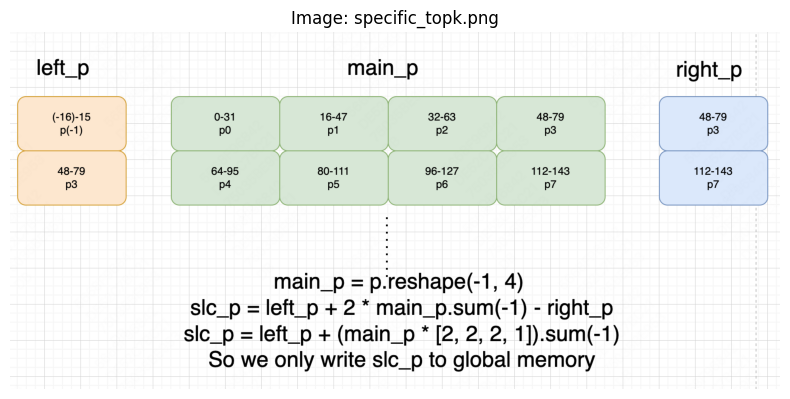

In [7]:
display_image("./imgs/specific_topk.png")

In [10]:
from flash_nsa.ops.compress_attn import compress_attn
from flash_nsa.ops.topk import slc_topk_indices
device = "cuda"
dtype = torch.bfloat16

qh, kh, d, vd = 64, 4, 128, 128
t = 1024 * 64
x_cu_seqlens = generate_cu_seqlens(end=t, mean=t, std=0)
# t = 2048
# x_cu_seqlens = generate_cu_seqlens(end=t, mean=32, std=24)
NSAHelper.init_cu_seqlens(x_cu_seqlens)
y_cu_seqlens = NSAHelper.y_cu_seqlens
assert NSAHelper.kernel_size == 32
assert NSAHelper.stride == 16
assert NSAHelper.block_size == 64
assert NSAHelper.num_init_blocks >= 1

q = torch.randn(x_cu_seqlens[-1], qh, d, device=device, dtype=dtype).requires_grad_(True)
k = torch.randn(y_cu_seqlens[-1], kh, d, device=device, dtype=dtype).requires_grad_(True)
v = torch.randn(y_cu_seqlens[-1], kh, vd, device=device, dtype=dtype).requires_grad_(True)

_, lse = compress_attn(q, k, v)
# ignore_index must bigger than max_num_slc_blocks rather than -1. It's useful when compute slc_attn_bwd
# Setting this arg is only for verfiying the correctness with torch ops. deafult None
fp16_topk1, _ = slc_topk_indices(q, k, lse, fp32=False)
fp32_topk1, _ = slc_topk_indices(q, k, lse, fp32=True)
# maybe_efficient_version=True

fp16_topk2, p1 = slc_topk_indices(q, k, lse, fp32=False, maybe_efficient_version=True, scale_slc_p=False)
fp16_scale_topk2, p2 = slc_topk_indices(q, k, lse, fp32=False, maybe_efficient_version=True, scale_slc_p=True, return_slc_prob=True)
fp32_topk2, p3 = slc_topk_indices(q, k, lse, fp32=True, maybe_efficient_version=True)

# fp16_topk = fp16_topk.sort(-1)[0]
# fp32_topk = fp32_topk.sort(-1)[0]
# ref_topk = ref_topk.sort(-1)[0]

# When the seqlen is huge, the memory is big. save fp16 attn_prob is more fast and use 1/2 kernel peak memory. 
print((fp16_topk1.sort(-1)[0] != fp32_topk1.sort(-1)[0]).sum() / fp16_topk1.numel())
print((fp16_topk2.sort(-1)[0] != fp32_topk1.sort(-1)[0]).sum() / fp16_topk1.numel())
print((fp16_scale_topk2.sort(-1)[0] != fp32_topk1.sort(-1)[0]).sum() / fp16_topk1.numel())
print((fp32_topk2.sort(-1)[0] != fp32_topk1.sort(-1)[0]).sum() / fp16_topk1.numel())

print(triton.testing.do_bench(lambda: slc_topk_indices(q, k, lse, align=True,ignore_index=999999, fp32=False)))
print(triton.testing.do_bench(lambda: slc_topk_indices(q, k, lse, align=True,ignore_index=999999, fp32=True)))
print(triton.testing.do_bench(lambda: slc_topk_indices(q, k, lse, fp32=False, maybe_efficient_version=True, scale_slc_p=False), warmup=20, rep=50))
print(triton.testing.do_bench(lambda: slc_topk_indices(q, k, lse, fp32=False, maybe_efficient_version=True, scale_slc_p=True), warmup=20, rep=50))
print(triton.testing.do_bench(lambda: slc_topk_indices(q, k, lse, fp32=True, maybe_efficient_version=True), warmup=20, rep=50))

tensor(0.0029, device='cuda:0')
tensor(0.0082, device='cuda:0')
tensor(0.0029, device='cuda:0')
tensor(0., device='cuda:0')
7.122623993800237
7.635250608126323
8.22817595799764
8.204442818959555
8.336812782287598


# select_attn

In [2]:
from flash_nsa.ops.compress_attn import compress_attn
from flash_nsa.ops.select_attn import select_attn
from flash_nsa.ops.topk import slc_topk_indices, get_bind_from_find
from flash_nsa.ops.torch_ref import torch_slc_attn

device = "cuda"
dtype = torch.float16

qh, kh, d, vd =  64, 4, 128, 128
t = 8192
x_cu_seqlens = generate_cu_seqlens(end=t, mean=t, std=0)
b = len(x_cu_seqlens) - 1
NSAHelper.init_cu_seqlens(x_cu_seqlens)
y_cu_seqlens = NSAHelper.y_cu_seqlens
q1 = torch.randn(t, qh, d, device=device, dtype=dtype).requires_grad_(True)
k1 = torch.randn(t, kh, d, device=device, dtype=dtype).requires_grad_(True)
v1 = torch.randn(t, kh, vd, device=device, dtype=dtype).requires_grad_(True)
q2, k2, v2 = deepcopy(q1), deepcopy(k1), deepcopy(v1)
torch.cuda.empty_cache()

with torch.no_grad():
    _, lse = compress_attn(q1, k1[:y_cu_seqlens[-1]], v1[:y_cu_seqlens[-1]])
    topk,_ = slc_topk_indices(q1, k1[:y_cu_seqlens[-1]], lse, fp32=False, maybe_efficient_version=True, scale_slc_p=True)
    sort_topk = topk.sort(-1)[0]

y1 = select_attn(q1, k1, v1, topk)
dy = torch.randn_like(y1)
y1.backward(dy, retain_graph=True)

def func():
    y2_list = []
    for idx in range(b):
        y2 = torch_slc_attn(q2[x_cu_seqlens[idx]:x_cu_seqlens[idx+1]], 
                            k2[x_cu_seqlens[idx]:x_cu_seqlens[idx+1]], 
                            v2[x_cu_seqlens[idx]:x_cu_seqlens[idx+1]], 
                            topk=topk[:,x_cu_seqlens[idx]:x_cu_seqlens[idx+1]],
                            block_size=NSAHelper.block_size,)
        y2_list.append(y2)
    y2 = torch.cat(y2_list, 0)
    return y2
y2 = func()
y2.backward(dy, retain_graph=True)

compare(y1, y2)
compare(q1.grad, q2.grad)
compare(k1.grad, k2.grad)
compare(v1.grad, v2.grad)

print(triton.testing.do_bench(lambda: func()))
print(triton.testing.do_bench(lambda: y2.backward(dy, retain_graph=True), grad_to_none=[q2, k2, v2], warmup=100, rep=500))
print(triton.testing.do_bench(lambda: select_attn(q1, k1, v1, topk), warmup=100, rep=500))
print(triton.testing.do_bench(lambda: y1.backward(dy, retain_graph=True), grad_to_none=[q1, k1, v1], warmup=100, rep=500))

max_diff: 0.002197265625, mean_diff: 2.6166439056396484e-05
max_diff: 0.0029296875, mean_diff: 2.765655517578125e-05
max_diff: 0.0078125, mean_diff: 0.00010216236114501953
max_diff: 0.0078125, mean_diff: 9.578466415405273e-05
47.60007858276367
58.25114345550537
2.0585673081463782
5.033476076874078


In [5]:
# Cuda-based infllm_v2 equals to select_attn
from flash_nsa.ops.compress_attn import compress_attn
from flash_nsa.ops.select_attn import select_attn
from flash_nsa.ops.topk import slc_topk_indices
from infllm_v2 import infllmv2_sparse_attn_func
'''
git clone https://github.com/OpenBMB/infllmv2_cuda_impl.git --recursive
cd infllmv2_cuda_impl
python setup.py install
'''
device = "cuda"
dtype = torch.bfloat16

qh, kh, d, vd =  64, 4, 128, 128
t = 8192 * 8
x_cu_seqlens = generate_cu_seqlens(end=t, mean=t, std=0)
b = len(x_cu_seqlens) - 1
NSAHelper.init_cu_seqlens(x_cu_seqlens)
y_cu_seqlens = NSAHelper.y_cu_seqlens


q1 = torch.randn(t, qh, d, device=device, dtype=dtype).requires_grad_(True)
k1 = torch.randn(t, kh, d, device=device, dtype=dtype).requires_grad_(True)
v1 = torch.randn(t, kh, vd, device=device, dtype=dtype).requires_grad_(True)
q2, k2, v2 = deepcopy(q1), deepcopy(k1), deepcopy(v1)
torch.cuda.empty_cache()

with torch.no_grad():
    _, lse = compress_attn(q1, k1[:y_cu_seqlens[-1]], v1[:y_cu_seqlens[-1]])
    topk,_ = slc_topk_indices(q1, k1[:y_cu_seqlens[-1]], lse, fp32=False, maybe_efficient_version=True, scale_slc_p=True)
    sort_topk = topk.sort(-1)[0]

y1 = select_attn(q1, k1, v1, topk)
y2 = infllmv2_sparse_attn_func(q2, k2, v2, x_cu_seqlens, x_cu_seqlens, sort_topk, NSAHelper.x_maxlen, NSAHelper.x_maxlen)
dy = torch.randn_like(y1)
y1.backward(dy, retain_graph=True)
y2.backward(dy, retain_graph=True)

compare(y1, y2)
compare(q1.grad, q2.grad)
compare(k1.grad, k2.grad)
compare(v1.grad, v2.grad)
time.sleep(2)
# infllmv2_sparse_attn_func's var is big
print(triton.testing.do_bench(lambda: infllmv2_sparse_attn_func(q2, k2, v2, x_cu_seqlens, x_cu_seqlens, sort_topk, NSAHelper.x_maxlen, NSAHelper.x_maxlen), warmup=100, rep=500))
print(triton.testing.do_bench(lambda: y2.backward(dy, retain_graph=True), grad_to_none=[q2, k2, v2], warmup=100, rep=500))
time.sleep(2)
print(triton.testing.do_bench(lambda: select_attn(q1, k1, v1, topk), warmup=100, rep=500))
print(triton.testing.do_bench(lambda: y1.backward(dy, retain_graph=True), grad_to_none=[q1, k1, v1], warmup=100, rep=500))

max_diff: 0.00390625, mean_diff: 6.29425048828125e-05
max_diff: 0.0078125, mean_diff: 2.288818359375e-05
max_diff: 0.0625, mean_diff: 9.5367431640625e-05
max_diff: 0.0625, mean_diff: 6.973743438720703e-06
19.050519943237305
208.23299407958984
13.163713738724992
31.290018463134764


# combine

In [26]:
from flash_nsa.ops.combine import fused_sigmoid_combine
from flash_nsa.ops.torch_ref import torch_sigmoid_combine

dtype = torch.bfloat16
device = "cuda"



t, qh, d = 8192 * 4, 64, 128 

a1 = torch.randn(t, qh, d, device=device, dtype=dtype).requires_grad_(True)
b1 = torch.randn_like(a1).requires_grad_(True)
c1 = torch.randn_like(a1).requires_grad_(True)
w1 = torch.randn(t, qh, 3, device=device, dtype=dtype).requires_grad_(True)
a2, b2, c2, w2 = deepcopy(a1), deepcopy(b1), deepcopy(c1), deepcopy(w1)

y1 = fused_sigmoid_combine(a1, b1, c1, w1)
dy = torch.randn_like(y1)
y1.backward(dy, retain_graph=True)
y2 = torch_sigmoid_combine(a2, b2, c2, w2)
y2.backward(dy, retain_graph=True)

compare(y1, y2)
compare(a1.grad, a2.grad)
compare(b1.grad, b2.grad)
compare(c1.grad, c2.grad)
compare(w1.grad, w2.grad)
print(triton.testing.do_bench(lambda: torch_sigmoid_combine(a2, b2, c2, w2)))
print(triton.testing.do_bench(lambda: y2.backward(dy, retain_graph=True), grad_to_none=[a2, b2, c2, w2]))
print(triton.testing.do_bench(lambda: fused_sigmoid_combine(a1, b1, c1, w1)))
print(triton.testing.do_bench(lambda: y1.backward(dy, retain_graph=True), grad_to_none=[a1, b1, c1, w1]))

max_diff: 0.03125, mean_diff: 0.001861572265625
max_diff: 0.03125, mean_diff: 0.000553131103515625
max_diff: 0.03125, mean_diff: 0.000553131103515625
max_diff: 0.03125, mean_diff: 0.000553131103515625
max_diff: 0.1875, mean_diff: 0.01092529296875
2.719632455280849
4.592259827782126
0.5411303406808434
1.1202291998752327


# NSA

In [2]:
from flash_nsa.config import NSAConfig
from flash_nsa.modules.hf_level_nsa import HFNSACore, NSAHelper
from flash_nsa.modules.megatron_level_nsa import NSACore as MegatronNSACore

dtype = torch.bfloat16
device = "cuda"
config = NSAConfig(
    # qk_head_dim=192,
    qk_head_dim=128,
    v_head_dim=128,
    kernel_size=32,
    stride=16,
    num_heads=64,
    num_kv_heads=4,
    # recompute_cmp_kv=True, 
    # recompute_cmp_o=True, 
    # recompute_swa_o=True, 
    # recompute_slc_o=True
    )
config.cmp_v_method = "mean"

qh = config.num_heads
kh = config.num_kv_heads
d = config.qk_head_dim
vd = config.v_head_dim

t = 1024 * 64
cu_seqlens = generate_cu_seqlens(t, t, 0)
q = torch.randn(t, qh, d, device=device, dtype=dtype).requires_grad_(True)
k = torch.randn(t, kh, d, device=device, dtype=dtype).requires_grad_(True)
v = torch.randn(t, kh, vd, device=device, dtype=dtype).requires_grad_(True)
weight = torch.randn(t, qh, 3, device=device, dtype=dtype).requires_grad_(True)
nsa = HFNSACore(config).to(q)
mnsa = MegatronNSACore(config).to(q)
y = nsa(q, k, v, weight, cu_seqlens, bench=True)
if not isinstance(y, torch.Tensor):
    y, df = y
dy = torch.randn_like(y)
y.backward(dy, retain_graph=True)
dq, dk, dv = q.grad, k.grad, v.grad
q.grad, k.grad, v.grad = None, None, None
y2 = mnsa(q, k, v, weight, cu_seqlens)
y2.backward(dy, retain_graph=True)

compare(y, y2, "o, hf vs megatron")
compare(dq, q.grad, "q.grad, hf vs megatron")
compare(dk, k.grad, "k.grad, hf vs megatron")
compare(dv, v.grad, "v.grad, hf vs megatron")

forward time (ms) s: 
cmp_k       0.030037
cmp_v       0.030075
cmp_o       8.791024
top_k       8.249184
slc_o      13.269399
swa_o       4.890338
combine     1.106699
dtype: float64
o, hf vs megatron: max_diff: 0.0, mean_diff: 0.0
q.grad, hf vs megatron: max_diff: 0.0009765625, mean_diff: 5.343281372915953e-12
k.grad, hf vs megatron: max_diff: 0.03125, mean_diff: 0.0002651214599609375
v.grad, hf vs megatron: max_diff: 0.0625, mean_diff: 0.000278472900390625


In [3]:
print(triton.testing.do_bench(lambda: nsa(q, k, v, weight, cu_seqlens, bench=False), warmup=100, rep=500))
print(triton.testing.do_bench(lambda: mnsa(q, k, v, weight, cu_seqlens), warmup=100, rep=500))
print(triton.testing.do_bench(lambda: y.backward(dy, retain_graph=True), grad_to_none=[q, k, v, weight], warmup=100, rep=500))
print(triton.testing.do_bench(lambda: y2.backward(dy, retain_graph=True), grad_to_none=[q, k, v, weight], warmup=100, rep=500))

35.984885875995346
36.15188789367676
80.54623921712239
79.17520395914714


## benchmark

### forward

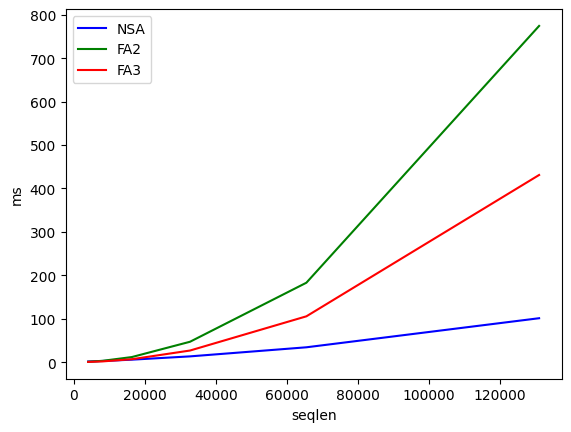

num_head=64, num_kv_head=4, head_dim=128, forward:
     seqlen         NSA         FA2         FA3
0    4096.0    1.370335    0.826244    0.468241
1    8192.0    2.629667    3.054532    1.693475
2   16384.0    5.659996   11.676872    6.690040
3   32768.0   13.236773   46.911713   26.711466
4   65536.0   34.162239  182.879227  105.494339
5  131072.0  101.123390  774.342285  431.018188


In [2]:
from flash_nsa.config import NSAConfig
from flash_nsa.modules.megatron_level_nsa import NSACore as MegatronNSACore

torch.cuda.empty_cache()
@triton.testing.perf_report(
    triton.testing.Benchmark(
        x_names=['seqlen'],  # argument names to use as an x-axis for the plot
        x_vals=[4096 * 2**i for i in range(0, 6)],  # different possible values for `x_name`
        line_arg='provider',  # argument name whose value corresponds to a different line in the plot
        line_vals=['NSA', 'FA2', 'FA3'],  # possible values for `line_arg``
        line_names=[
            "NSA",
            "FA2",
            "FA3",
        ],  # label name for the lines
        styles=[('blue', '-'), ('green', '-'), ('red', '-')],  # line styles
        ylabel="ms",  # label name for the y-axis
        plot_name="num_head=64, num_kv_head=4, head_dim=128, forward",  # name for the plot. Used also as a file name for saving the plot.
        args={'qh':64, 'kh':4, 'd':128},  # values for function arguments not in `x_names` and `y_name`
    ))
def benchmark(qh, kh, seqlen, d, provider):
    device = 'cuda'
    dtype = torch.bfloat16

    def alloc_fn(size: int, align: int, _):
        return torch.empty(size, dtype=torch.int8, device="cuda")
    triton.set_allocator(alloc_fn)

    cu_seqlens = torch.tensor([0, seqlen], device=device).cumsum(0).to(torch.int32)
    q = torch.randn(seqlen, qh, d, device=device, dtype=dtype).requires_grad_(True)
    k = torch.randn(seqlen, kh, d, device=device, dtype=dtype).requires_grad_(True)
    v = torch.randn(seqlen, kh, d, device=device, dtype=dtype).requires_grad_(True)
    
    stream = torch.cuda.Stream()
    torch.cuda.set_stream(stream)
    if provider == 'NSA':
        config = NSAConfig()
        weight = torch.randn(seqlen, qh, 3, device=device, dtype=dtype).requires_grad_(True)
        nsa = MegatronNSACore(config).to(q)
        ms = triton.testing.do_bench(lambda: nsa(q, k, v, weight, cu_seqlens))
    if provider == 'FA2':
        from flash_attn import flash_attn_varlen_func
        ms = triton.testing.do_bench(lambda: flash_attn_varlen_func(q, k, v, cu_seqlens, cu_seqlens, seqlen, seqlen, causal=True))
    if provider == 'FA3':
        from flash_attn_interface import flash_attn_varlen_func
        ms = triton.testing.do_bench(lambda: flash_attn_varlen_func(q, k, v, cu_seqlens, cu_seqlens, seqlen, seqlen, causal=True))
    return ms
benchmark.run(show_plots=True, print_data=True)

### backward

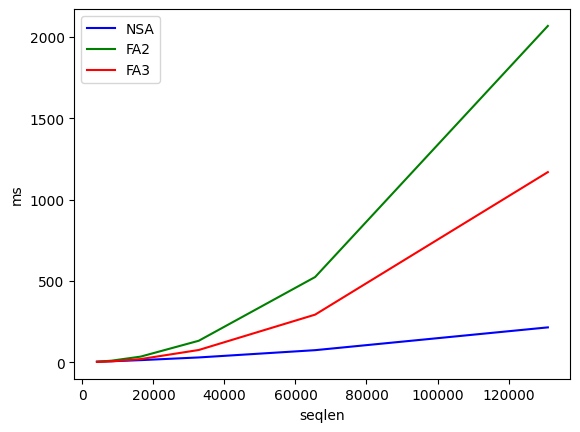

num_head=64, num_kv_head=4, head_dim=128, backward:
     seqlen         NSA          FA2          FA3
0    4096.0    2.771820     2.503270     1.379237
1    8192.0    5.570735     9.009357     5.013627
2   16384.0   12.322220    33.972258    18.735635
3   32768.0   28.959669   131.634491    74.799133
4   65536.0   73.688576   523.686218   292.343994
5  131072.0  213.904358  2068.491943  1169.143921


In [3]:
from flash_nsa.config import NSAConfig
from flash_nsa.modules.megatron_level_nsa import NSACore as MegatronNSACore

torch.cuda.empty_cache()
@triton.testing.perf_report(
    triton.testing.Benchmark(
        x_names=['seqlen'],  # argument names to use as an x-axis for the plot
        x_vals=[4096 * 2**i for i in range(0, 6)],  # different possible values for `x_name`
        line_arg='provider',  # argument name whose value corresponds to a different line in the plot
        line_vals=['NSA', 'FA2', 'FA3'],  # possible values for `line_arg``
        line_names=[
            "NSA",
            "FA2",
            "FA3",
        ],  # label name for the lines
        styles=[('blue', '-'), ('green', '-'), ('red', '-')],  # line styles
        ylabel="ms",  # label name for the y-axis
        plot_name="num_head=64, num_kv_head=4, head_dim=128, backward",  # name for the plot. Used also as a file name for saving the plot.
        args={'qh':64, 'kh':4, 'd':128},  # values for function arguments not in `x_names` and `y_name`
    ))
def benchmark(qh, kh, seqlen, d, provider):
    device = 'cuda'
    dtype = torch.bfloat16

    def alloc_fn(size: int, align: int, _):
        return torch.empty(size, dtype=torch.int8, device="cuda")
    triton.set_allocator(alloc_fn)

    cu_seqlens = torch.tensor([0, seqlen], device=device).cumsum(0).to(torch.int32)
    q = torch.randn(seqlen, qh, d, device=device, dtype=dtype).requires_grad_(True)
    k = torch.randn(seqlen, kh, d, device=device, dtype=dtype).requires_grad_(True)
    v = torch.randn(seqlen, kh, d, device=device, dtype=dtype).requires_grad_(True)
    do = torch.randn_like(q)
    
    stream = torch.cuda.Stream()
    torch.cuda.set_stream(stream)
    if provider == 'NSA':
        config = NSAConfig()
        weight = torch.randn(seqlen, qh, 3, device=device, dtype=dtype).requires_grad_(True)
        nsa = MegatronNSACore(config).to(q)
        o = nsa(q, k, v, weight, cu_seqlens)
        ms = triton.testing.do_bench(lambda: o.backward(do, retain_graph=True), grad_to_none=[q, k, v, weight])
    if provider == 'FA2':
        try:
            from flash_attn import flash_attn_varlen_func
        except:
            return 0
        o = flash_attn_varlen_func(q, k, v, cu_seqlens, cu_seqlens, seqlen, seqlen, causal=True)
        ms = triton.testing.do_bench(lambda: o.backward(do, retain_graph=True), grad_to_none=[q, k, v])
    if provider == 'FA3':
        try:
            from flash_attn_interface import flash_attn_varlen_func
        except:
            return 0
        o = flash_attn_varlen_func(q, k, v, cu_seqlens, cu_seqlens, seqlen, seqlen, causal=True)
        ms = triton.testing.do_bench(lambda: o.backward(do, retain_graph=True), grad_to_none=[q, k, v])
    return ms
benchmark.run(show_plots=True, print_data=True)

### gain point

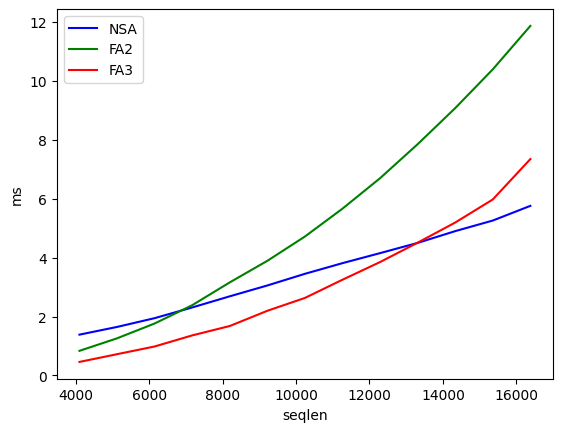

num_head=64, num_kv_head=4, head_dim=128, forward:
     seqlen       NSA        FA2       FA3
0    4096.0  1.383824   0.834107  0.457720
1    5120.0  1.645707   1.258864  0.720130
2    6144.0  1.943572   1.761983  0.981809
3    7168.0  2.307089   2.383372  1.358128
4    8192.0  2.685509   3.158247  1.677278
5    9216.0  3.053576   3.890414  2.193622
6   10240.0  3.449713   4.715438  2.630388
7   11264.0  3.811925   5.662297  3.249188
8   12288.0  4.152224   6.696870  3.849107
9   13312.0  4.499190   7.850846  4.507141
10  14336.0  4.899659   9.076986  5.190558
11  15360.0  5.258820  10.393396  5.974498
12  16384.0  5.757832  11.868184  7.345970


In [4]:
from flash_nsa.config import NSAConfig
from flash_nsa.modules.megatron_level_nsa import NSACore as MegatronNSACore

torch.cuda.empty_cache()
@triton.testing.perf_report(
    triton.testing.Benchmark(
        x_names=['seqlen'],  # argument names to use as an x-axis for the plot
        x_vals=[4096 + 1024 * i for i in range(0, 13)],  # different possible values for `x_name`
        line_arg='provider',  # argument name whose value corresponds to a different line in the plot
        line_vals=['NSA', 'FA2', 'FA3'],  # possible values for `line_arg``
        line_names=[
            "NSA",
            "FA2",
            "FA3",
        ],  # label name for the lines
        styles=[('blue', '-'), ('green', '-'), ('red', '-')],  # line styles
        ylabel="ms",  # label name for the y-axis
        plot_name="num_head=64, num_kv_head=4, head_dim=128, forward",  # name for the plot. Used also as a file name for saving the plot.
        args={'qh':64, 'kh':4, 'd':128},  # values for function arguments not in `x_names` and `y_name`
    ))
def benchmark(qh, kh, seqlen, d, provider):
    device = 'cuda'
    dtype = torch.bfloat16

    def alloc_fn(size: int, align: int, _):
        return torch.empty(size, dtype=torch.int8, device="cuda")
    triton.set_allocator(alloc_fn)

    cu_seqlens = torch.tensor([0, seqlen], device=device).cumsum(0).to(torch.int32)
    q = torch.randn(seqlen, qh, d, device=device, dtype=dtype).requires_grad_(True)
    k = torch.randn(seqlen, kh, d, device=device, dtype=dtype).requires_grad_(True)
    v = torch.randn(seqlen, kh, d, device=device, dtype=dtype).requires_grad_(True)
    
    stream = torch.cuda.Stream()
    torch.cuda.set_stream(stream)
    if provider == 'NSA':
        config = NSAConfig()
        weight = torch.randn(seqlen, qh, 3, device=device, dtype=dtype).requires_grad_(True)
        nsa = MegatronNSACore(config).to(q)
        ms = triton.testing.do_bench(lambda: nsa(q, k, v, weight, cu_seqlens))
    if provider == 'FA2':
        from flash_attn import flash_attn_varlen_func
        ms = triton.testing.do_bench(lambda: flash_attn_varlen_func(q, k, v, cu_seqlens, cu_seqlens, seqlen, seqlen, causal=True))
    if provider == 'FA3':
        from flash_attn_interface import flash_attn_varlen_func
        ms = triton.testing.do_bench(lambda: flash_attn_varlen_func(q, k, v, cu_seqlens, cu_seqlens, seqlen, seqlen, causal=True))
    return ms
benchmark.run(show_plots=True, print_data=True)

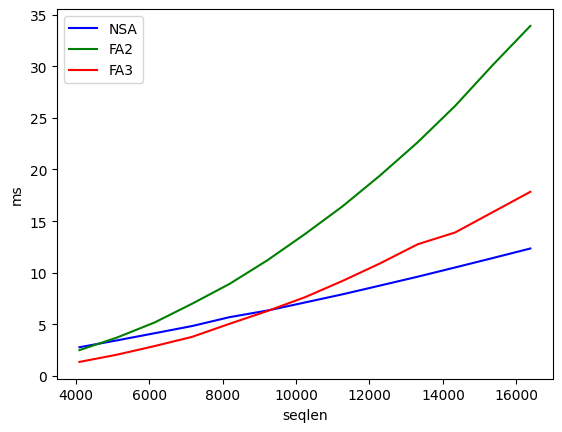

num_head=64, num_kv_head=4, head_dim=128, backward:
     seqlen        NSA        FA2        FA3
0    4096.0   2.787858   2.506826   1.365444
1    5120.0   3.452423   3.727386   2.066589
2    6144.0   4.143317   5.185170   2.899137
3    7168.0   4.841617   7.005282   3.794721
4    8192.0   5.704186   8.933325   5.065294
5    9216.0   6.340087  11.204904   6.289047
6   10240.0   7.120281  13.742171   7.628209
7   11264.0   7.912084  16.429108   9.208367
8   12288.0   8.760027  19.420800  10.906944
9   13312.0   9.617056  22.629160  12.757252
10  14336.0  10.515869  26.164778  13.904352
11  15360.0  11.425820  30.118506  15.872272
12  16384.0  12.349074  33.903296  17.839693


In [5]:
from flash_nsa.config import NSAConfig
from flash_nsa.modules.megatron_level_nsa import NSACore as MegatronNSACore

torch.cuda.empty_cache()
@triton.testing.perf_report(
    triton.testing.Benchmark(
        x_names=['seqlen'],  # argument names to use as an x-axis for the plot
        x_vals=[4096 + 1024 * i for i in range(0, 13)],  # different possible values for `x_name`
        line_arg='provider',  # argument name whose value corresponds to a different line in the plot
        line_vals=['NSA', 'FA2', 'FA3'],  # possible values for `line_arg``
        line_names=[
            "NSA",
            "FA2",
            "FA3",
        ],  # label name for the lines
        styles=[('blue', '-'), ('green', '-'), ('red', '-')],  # line styles
        ylabel="ms",  # label name for the y-axis
        plot_name="num_head=64, num_kv_head=4, head_dim=128, backward",  # name for the plot. Used also as a file name for saving the plot.
        args={'qh':64, 'kh':4, 'd':128},  # values for function arguments not in `x_names` and `y_name`
    ))
def benchmark(qh, kh, seqlen, d, provider):
    device = 'cuda'
    dtype = torch.bfloat16

    def alloc_fn(size: int, align: int, _):
        return torch.empty(size, dtype=torch.int8, device="cuda")
    triton.set_allocator(alloc_fn)

    cu_seqlens = torch.tensor([0, seqlen], device=device).cumsum(0).to(torch.int32)
    q = torch.randn(seqlen, qh, d, device=device, dtype=dtype).requires_grad_(True)
    k = torch.randn(seqlen, kh, d, device=device, dtype=dtype).requires_grad_(True)
    v = torch.randn(seqlen, kh, d, device=device, dtype=dtype).requires_grad_(True)
    do = torch.randn_like(q)
    
    stream = torch.cuda.Stream()
    torch.cuda.set_stream(stream)
    if provider == 'NSA':
        config = NSAConfig()
        weight = torch.randn(seqlen, qh, 3, device=device, dtype=dtype).requires_grad_(True)
        nsa = MegatronNSACore(config).to(q)
        o = nsa(q, k, v, weight, cu_seqlens)
        ms = triton.testing.do_bench(lambda: o.backward(do, retain_graph=True), grad_to_none=[q, k, v, weight])
    if provider == 'FA2':
        try:
            from flash_attn import flash_attn_varlen_func
        except:
            return 0
        o = flash_attn_varlen_func(q, k, v, cu_seqlens, cu_seqlens, seqlen, seqlen, causal=True)
        ms = triton.testing.do_bench(lambda: o.backward(do, retain_graph=True), grad_to_none=[q, k, v])
    if provider == 'FA3':
        try:
            from flash_attn_interface import flash_attn_varlen_func
        except:
            return 0
        o = flash_attn_varlen_func(q, k, v, cu_seqlens, cu_seqlens, seqlen, seqlen, causal=True)
        ms = triton.testing.do_bench(lambda: o.backward(do, retain_graph=True), grad_to_none=[q, k, v])
    return ms
benchmark.run(show_plots=True, print_data=True)

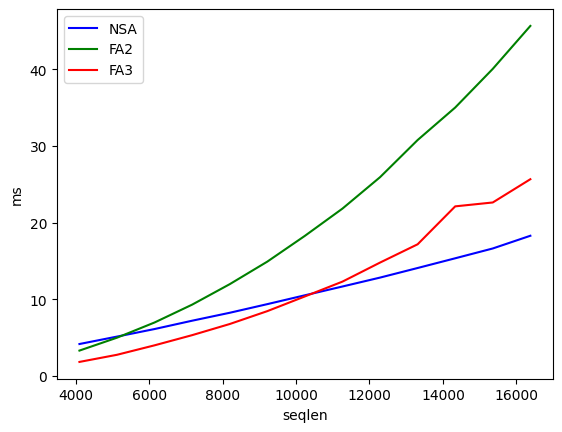

num_head=64, num_kv_head=4, head_dim=128, forward + backward:
     seqlen        NSA        FA2        FA3
0    4096.0   4.185116   3.328314   1.850062
1    5120.0   5.153502   5.012054   2.781427
2    6144.0   6.140277   6.995335   4.015884
3    7168.0   7.226517   9.322736   5.342618
4    8192.0   8.260646  11.991636   6.794184
5    9216.0   9.386453  14.932440   8.474086
6   10240.0  10.541426  18.293620  10.391339
7   11264.0  11.686464  21.848267  12.324539
8   12288.0  12.848530  25.944415  14.807383
9   13312.0  14.098859  30.787786  17.191744
10  14336.0  15.365877  35.027727  22.138432
11  15360.0  16.646502  40.069649  22.645360
12  16384.0  18.304672  45.670176  25.678582


In [8]:
from flash_nsa.config import NSAConfig
from flash_nsa.modules.megatron_level_nsa import NSACore as MegatronNSACore

torch.cuda.empty_cache()
@triton.testing.perf_report(
    triton.testing.Benchmark(
        x_names=['seqlen'],  # argument names to use as an x-axis for the plot
        x_vals=[4096 + 1024 * i for i in range(0, 13)],  # different possible values for `x_name`
        line_arg='provider',  # argument name whose value corresponds to a different line in the plot
        line_vals=['NSA', 'FA2', 'FA3'],  # possible values for `line_arg``
        line_names=[
            "NSA",
            "FA2",
            "FA3",
        ],  # label name for the lines
        styles=[('blue', '-'), ('green', '-'), ('red', '-')],  # line styles
        ylabel="ms",  # label name for the y-axis
        plot_name="num_head=64, num_kv_head=4, head_dim=128, forward + backward",  # name for the plot. Used also as a file name for saving the plot.
        args={'qh':64, 'kh':4, 'd':128},  # values for function arguments not in `x_names` and `y_name`
    ))
def benchmark(qh, kh, seqlen, d, provider):
    device = 'cuda'
    dtype = torch.bfloat16

    def alloc_fn(size: int, align: int, _):
        return torch.empty(size, dtype=torch.int8, device="cuda")
    triton.set_allocator(alloc_fn)

    cu_seqlens = torch.tensor([0, seqlen], device=device).cumsum(0).to(torch.int32)
    q = torch.randn(seqlen, qh, d, device=device, dtype=dtype).requires_grad_(True)
    k = torch.randn(seqlen, kh, d, device=device, dtype=dtype).requires_grad_(True)
    v = torch.randn(seqlen, kh, d, device=device, dtype=dtype).requires_grad_(True)
    do = torch.randn_like(q)
    
    stream = torch.cuda.Stream()
    torch.cuda.set_stream(stream)
    if provider == 'NSA':
        config = NSAConfig()
        weight = torch.randn(seqlen, qh, 3, device=device, dtype=dtype).requires_grad_(True)
        nsa = MegatronNSACore(config).to(q)
        ms = triton.testing.do_bench(lambda: nsa(q, k, v, weight, cu_seqlens).backward(do, retain_graph=True), grad_to_none=[q, k, v, weight])
    if provider == 'FA2':
        try:
            from flash_attn import flash_attn_varlen_func
        except:
            return 0
        ms = triton.testing.do_bench(lambda: flash_attn_varlen_func(q, k, v, cu_seqlens, cu_seqlens, seqlen, seqlen, causal=True).backward(do, retain_graph=True), grad_to_none=[q, k, v])
    if provider == 'FA3':
        try:
            from flash_attn_interface import flash_attn_varlen_func
        except:
            return 0
        ms = triton.testing.do_bench(lambda: flash_attn_varlen_func(q, k, v, cu_seqlens, cu_seqlens, seqlen, seqlen, causal=True).backward(do, retain_graph=True), grad_to_none=[q, k, v])
    return ms
benchmark.run(show_plots=True, print_data=True)

### Time proportion

           4096      8192      16384     32768      65536      131072
cmp_k    0.063644  0.063581  0.063839  0.065487   0.075406   0.093001
cmp_v    0.063293  0.063613  0.064349  0.065017   0.076171   0.092567
cmp_o    0.120202  0.278861  0.760415  2.410876   8.839117  33.030773
top_k    0.100668  0.221236  0.678043  2.372213   8.964342  35.067280
slc_o    0.608174  1.397696  3.050230  6.470797  13.279620  27.480703
swa_o    0.192841  0.378506  0.758589  1.516005   3.068479   6.083665
combine  0.072421  0.136590  0.267354  0.542050   1.103587   2.202236


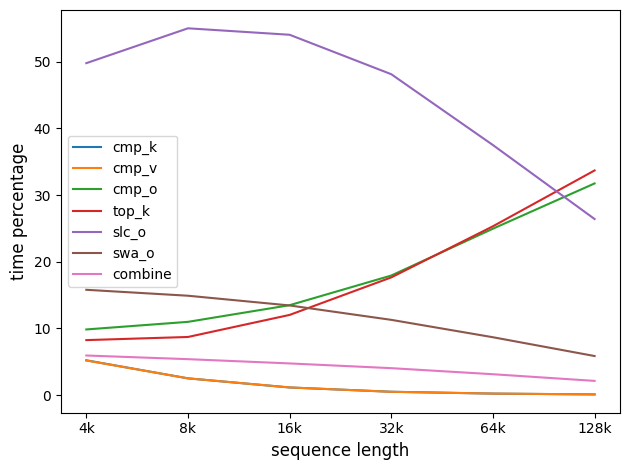

         4096    8192    16384   32768   65536   131072
cmp_k      5.21    2.50    1.13    0.49    0.21    0.09
cmp_v      5.18    2.50    1.14    0.48    0.22    0.09
cmp_o      9.84   10.98   13.48   17.93   24.96   31.75
top_k      8.24    8.71   12.02   17.65   25.32   33.70
slc_o     49.80   55.03   54.06   48.14   37.51   26.41
swa_o     15.79   14.90   13.44   11.28    8.67    5.85
combine    5.93    5.38    4.74    4.03    3.12    2.12


In [6]:
from flash_nsa.config import NSAConfig
from flash_nsa.modules.hf_level_nsa import HFNSACore, NSAHelper, pd
import matplotlib.pyplot as plt

dtype = torch.bfloat16
device = "cuda"
config = NSAConfig()
config.cmp_v_method = "mean"

qh = config.num_heads
kh = config.num_kv_heads
d = config.head_dim

nsa = HFNSACore(config).to(device).to(dtype)
dfs = []
columns = []
for i in range(6):
    splits = [4096 * 2 ** i]
    t = splits[0]
    cu_seqlens = torch.tensor([0] + splits, device=device).cumsum(0).to(torch.int32)
    q = torch.randn(t, qh, d, device=device, dtype=dtype).requires_grad_(True)
    k = torch.randn(t, kh, d, device=device, dtype=dtype).requires_grad_(True)
    v = torch.randn(t, kh, d, device=device, dtype=dtype).requires_grad_(True)
    weight = torch.randn(t, qh, 3, device=device, dtype=dtype).requires_grad_(True)
    y,df = nsa(q, k, v, weight, cu_seqlens, bench=True, print_result=False)
    dfs.append(df)
    columns.append(t)
result = pd.concat(dfs, axis=1)
result.columns = columns
print(result)
result = result.apply(lambda x: round(x / x.sum() * 100, 2), 0)
columns = [f"{4* 2 ** i}k" for i in range(6)]
for name in result.index:
    row = result.loc[name]
    plt.plot(columns, result.loc[name], label=name)
# 添加标题和轴标签（假设你知道这些信息的来源）
plt.title('', fontsize=16)
plt.xlabel('sequence length', fontsize=12)
plt.ylabel('time percentage', fontsize=12)
plt.legend(
    loc='best',           # 自动选择最佳位置
    frameon=True,         # 添加图例外框
    fancybox=True,        # 圆角框
    shadow=False          # 无阴影
)
# 自动调整布局
plt.tight_layout()
# 显示图形
plt.show()
plt.show()
print(result)

# others

## act
For compress kv, please see nsa_hf_level.py

In [3]:
from flash_nsa.ops.act import swiglu_impl, sigmoid_mul_impl
from flash_nsa.ops.torch_ref import torch_sigmoid_mul, torch_swiglu

dtype = torch.bfloat16
device = "cuda"
t, h, d = 8192 * 4, 32, 128
x_cu_seqlens = generate_cu_seqlens(end=t, mean=t//4, std=512)
b = len(x_cu_seqlens) - 1

NSAHelper.init_cu_seqlens(x_cu_seqlens)

x1 = torch.randn(t, h, d * 2, device=device, dtype=dtype)
x1.requires_grad_(True)
x2 = deepcopy(x1)

# swiglu
y1 = swiglu_impl(x1)
dy = torch.randn_like(y1)
y2 = torch_swiglu(x2)
y1.backward(dy, retain_graph=True)
y2.backward(dy, retain_graph=True)
compare(y1, y2)
compare(x1.grad, x2.grad)
print(triton.testing.do_bench(lambda: swiglu_impl(x1)))
print(triton.testing.do_bench(lambda: swiglu_impl(x1).backward(dy, retain_graph=True), grad_to_none=[x1]))
print(triton.testing.do_bench(lambda: torch_swiglu(x2)))
print(triton.testing.do_bench(lambda: torch_swiglu(x2).backward(dy, retain_graph=True), grad_to_none=[x2]))


x1 = torch.randn(t, h, d * 2, device=device, dtype=dtype)
x1.requires_grad_(True)
x2 = deepcopy(x1)
y1 = sigmoid_mul_impl(x1)
dy = torch.randn_like(y1)
y2 = torch_sigmoid_mul(x2)
y1.backward(dy, retain_graph=True)
y2.backward(dy, retain_graph=True)
compare(y1, y2)
compare(x1.grad, x2.grad)
print(triton.testing.do_bench(lambda: sigmoid_mul_impl(x1)))
print(triton.testing.do_bench(lambda: sigmoid_mul_impl(x1).backward(dy, retain_graph=True), grad_to_none=[x1]))
print(triton.testing.do_bench(lambda: torch_sigmoid_mul(x2)))
print(triton.testing.do_bench(lambda: torch_sigmoid_mul(x2).backward(dy, retain_graph=True), grad_to_none=[x2]))


max_diff: 0.0625, mean_diff: 0.0004749298095703125
max_diff: 0.0625, mean_diff: 0.00046539306640625
0.19987468083162566
0.5129341828722914
0.7171717500314116
2.0977600048749876
max_diff: 0.03125, mean_diff: 0.000553131103515625
max_diff: 0.03125, mean_diff: 0.00045013427734375
0.19885381847232966
0.5121930717420178
0.7211044994182885
1.8740777608960173


## reorder

reoder kv or dkdv for cp

inplace op, can save more memory when kv length is huge

In [5]:
from flash_nsa.ops.reorder import reorder
from flash_nsa.ops.torch_ref import torch_reorder

dtype = torch.bfloat16
device = "cuda"

t, h, d = 8192 * 16, 1, 128
world_size = 8
inplace = True

k = torch.randn(t, h, d, device=device, dtype=dtype)

shuffle_k = torch_reorder(k, world_size=world_size, shuffle_mode="shuffle")
reorder(k, world_size=world_size, shuffle_mode="shuffle", inplace=inplace)
compare(shuffle_k, k)

unshuffle_k = torch_reorder(k, world_size=world_size, shuffle_mode="unshuffle")
reorder(k, world_size=world_size, shuffle_mode="unshuffle", inplace=inplace)
compare(unshuffle_k, k)

print(triton.testing.do_bench(lambda: reorder(k, world_size=world_size, shuffle_mode="unshuffle", inplace=inplace)))
print(triton.testing.do_bench(lambda: torch_reorder(k, world_size=world_size, shuffle_mode="shuffle")))
print(triton.testing.do_bench(lambda: reorder(k, world_size=world_size, shuffle_mode="shuffle", inplace=inplace)))
print(triton.testing.do_bench(lambda: torch_reorder(k, world_size=world_size, shuffle_mode="unshuffle")))


max_diff: 0.0, mean_diff: 0.0
max_diff: 0.0, mean_diff: 0.0
0.024855457354822884
0.036709844223926945
0.0231757046867337
0.03682137485774397


## rope

In [6]:
from flash_nsa.ops.rope import fused_apply_rope
from flash_nsa.ops.torch_ref import apply_rotary_pos_emb

dtype = torch.bfloat16
device = "cuda"

b, s, qh, kh, d = 2, 8192, 64, 4, 128


q1 = torch.randn(b, s, qh, d, device=device, dtype=dtype).requires_grad_(True)
k1 = torch.randn(b, s, kh, d, device=device, dtype=dtype).requires_grad_(True)
cos = torch.randn(b, s, d, device=device, dtype=dtype).cos()
sin = torch.randn(b, s, d, device=device, dtype=dtype).sin()
q2, k2 = deepcopy(q1), deepcopy(k1)
dq, dk = torch.randn_like(q1), torch.randn_like(k1)

qe1, ke1 = fused_apply_rope(q1, k1, cos, sin, inplace=True)
qe2, ke2 = apply_rotary_pos_emb(q2, k2, cos, sin, unsqueeze_dim=-2)

compare(qe1, qe2)
compare(ke1, ke2)
# inplace op
torch.autograd.backward((qe1, ke1), (dq, dk), retain_graph=True)
torch.autograd.backward((qe2, ke2), (dq, dk), retain_graph=True)

compare(q1.grad, q2.grad)
compare(k1.grad, k2.grad)
print(triton.testing.do_bench(lambda: fused_apply_rope(q1, k1, cos, sin, inplace=True)))
print(triton.testing.do_bench(lambda: torch.autograd.backward((qe1, ke1), (dq, dk), retain_graph=True), grad_to_none=[q1, k1]))
print(triton.testing.do_bench(lambda: apply_rotary_pos_emb(q2, k2, cos, sin, unsqueeze_dim=-2)))
print(triton.testing.do_bench(lambda: torch.autograd.backward((qe2, ke2), (dq, dk), retain_graph=True), grad_to_none=[q2, k2]))

max_diff: 0.03125, mean_diff: 0.00116729736328125
max_diff: 0.03125, mean_diff: 0.00116729736328125
max_diff: 0.03125, mean_diff: 0.00116729736328125
max_diff: 0.03125, mean_diff: 0.00116729736328125
0.15285285188946673
0.3344419914207378
1.7284548566454934
1.8681690433750981


## gemm
- for main_grad acc

In [7]:
from flash_nsa.ops.gemm import gemm


dtype = torch.bfloat16
device = "cuda"

M, N, K = 8192, 8192 * 2, 4096
inp = torch.randn(M, K, device=device, dtype=dtype)
w = torch.randn(N, K, device=device, dtype=dtype)
persistent=True

out = gemm(inp, w, transpose_a=False, transpose_b=True, persistent=persistent)
ref_out = torch.matmul(inp, w.t())
compare(out, ref_out)
print(triton.testing.do_bench(lambda: gemm(inp, w, persistent=persistent)))
print(triton.testing.do_bench(lambda: torch.matmul(inp, w.t())))

dout = ref_out

dinp = gemm(dout, w, transpose_a=False, transpose_b=False, persistent=persistent)
ref_dinp = torch.matmul(dout, w)
compare(dinp, ref_dinp)
print(triton.testing.do_bench(lambda: gemm(dout, w, transpose_a=False, transpose_b=False, persistent=persistent)))
print(triton.testing.do_bench(lambda: torch.matmul(dout, w)))

main_grad = torch.randn_like(w, dtype=torch.float32)
ref_grad = main_grad + torch.matmul(dout.float().t(), inp.float())
gemm(dout, inp, transpose_a=True, transpose_b=False, out=main_grad, acc=True, persistent=persistent)
compare(ref_grad, main_grad)
print(triton.testing.do_bench(lambda: gemm(dout, inp, transpose_a=True, transpose_b=False, out=main_grad, acc=True, persistent=persistent)))
print(triton.testing.do_bench(lambda: main_grad + torch.matmul(dout.t(), inp)))

max_diff: 0.0, mean_diff: 0.0
1.5635087016750784
1.6211325868231352
max_diff: 0.0, mean_diff: 0.0
1.5919296026229859
1.5826474666595458
max_diff: 0.5703125, mean_diff: 0.06698312610387802
1.7120526099609117
1.8053264290678734


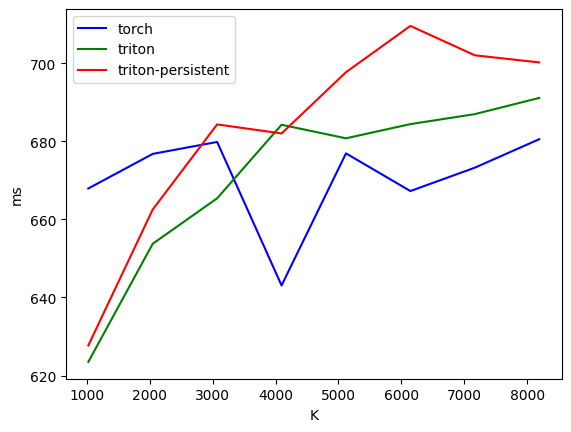

M=8192, N=4*K:
        K       torch      triton  triton-persistent
0  1024.0  667.912405  623.489584         627.702896
1  2048.0  676.768110  653.756071         662.522880
2  3072.0  679.826136  665.395393         684.319084
3  4096.0  643.069303  684.227409         681.998455
4  5120.0  676.895967  680.760835         697.688281
5  6144.0  667.252365  684.395316         709.541223
6  7168.0  673.233019  686.951706         702.016493
7  8192.0  680.529101  691.098659         700.192799


In [3]:
torch.cuda.empty_cache()
@triton.testing.perf_report(
    triton.testing.Benchmark(
        x_names=['K'],  # argument names to use as an x-axis for the plot
        x_vals=[1024 * i for i in range(1, 9)],  # different possible values for `x_name`
        line_arg='provider',  # argument name whose value corresponds to a different line in the plot
        line_vals=['torch', 'triton', 'triton-persistent'],  # possible values for `line_arg``
        line_names=[
            "torch",
            "triton",
            "triton-persistent"
        ],  # label name for the lines
        styles=[('blue', '-'), ('green', '-'), ('red', '-')],  # line styles
        ylabel="ms",  # label name for the y-axis
        plot_name="M=8192, N=4*K",  # name for the plot. Used also as a file name for saving the plot.
        args={"M":8192},  # values for function arguments not in `x_names` and `y_name`
    ))
def benchmark(M, K, provider):
    device = 'cuda'
    dtype = torch.bfloat16
    N = K * 4
    inp = torch.randn(M, K, device=device, dtype=dtype)
    w = torch.randn(N, K, device=device, dtype=dtype)
    
    stream = torch.cuda.Stream()
    torch.cuda.set_stream(stream)
    if provider == 'torch':
        ms = triton.testing.do_bench(lambda: torch.matmul(inp, w.t()), warmup=50, rep=500)
    if provider == 'triton':
        ms = triton.testing.do_bench(lambda: gemm(inp, w, persistent=False), warmup=50, rep=500)
    if provider == 'triton-persistent':
        ms = triton.testing.do_bench(lambda: gemm(inp, w, persistent=True), warmup=50, rep=500)
    f = lambda ms: M * N * K * 2 * 1e-9 / ms
    return f(ms)
benchmark.run(show_plots=True, print_data=True)

## DSA

In [7]:
from flash_nsa.ops.dsa import index_socre

device = "cuda"
dtype = torch.float16

qh, kh, d, vd =  64, 1, 128, 128
t = 8192
cu_seqlens = generate_cu_seqlens(end=t, mean=t, std=0)
b = len(cu_seqlens) - 1
maxlen = (cu_seqlens[1:] - cu_seqlens[:-1]).max().item()

q = torch.randn(t, qh, d, device=device, dtype=dtype)
k = torch.randn(t, kh, d, device=device, dtype=dtype)
w = torch.randn(t, qh, device=device, dtype=dtype)
s1 = index_socre(q, k, w, cu_seqlens, maxlen, mode=1, score_dtype=torch.float16)
s2 = index_socre(q, k, w, cu_seqlens, maxlen, mode=2)
topk = torch.topk(s1, k=2048, dim=-1)[1]

In [8]:
print(triton.testing.do_bench(lambda: index_socre(q, k, w, cu_seqlens, maxlen, mode=1)))
print(triton.testing.do_bench(lambda: index_socre(q, k, w, cu_seqlens, maxlen, mode=2)))
print(triton.testing.do_bench(lambda: torch.topk(s1, k=2048, dim=-1)[1]))

3.111220621293591
1.1128586742613051
0.8737815429668615


In [9]:
compare(s1.softmax(-1), s2.softmax(-1))

max_diff: 0.00484156608581543, mean_diff: 2.3565237938782957e-07


In [5]:
from flash_nsa.ops.dsa import index_socre, mqa_sparser_fwd, torch_mqa_sparser_ref, sparse_mla_fwd_interface

device = "cuda"
dtype = torch.bfloat16

qh, kh, d, vd =  64, 1, 128, 128
t = 8192
cu_seqlens = generate_cu_seqlens(end=t, mean=t, std=0)
b = len(cu_seqlens) - 1
maxlen = (cu_seqlens[1:] - cu_seqlens[:-1]).max().item()

q = torch.randn(t, qh, d, device=device, dtype=dtype)
k = torch.randn(t, kh, d, device=device, dtype=dtype)
w = torch.randn(t, qh, device=device, dtype=dtype)
s1 = index_socre(q, k, w, cu_seqlens, maxlen, mode=1, score_dtype=torch.float32)
s2 = index_socre(q, k, w, cu_seqlens, maxlen, mode=2)
index = torch.topk(s1, k=2048, dim=-1)[1]
int32_index = index.to(torch.int32)

d = 576
vd = 512
sm_scale = 192 ** -0.5
q = torch.randn(t, 64, d, device=device, dtype=dtype)
kv = torch.randn(t, 1, d, device=device, dtype=dtype)
# ref_o, p = torch_mqa_sparser_ref(q, kv, index, vd, sm_scale=sm_scale)
o, lse = mqa_sparser_fwd(q, kv, int32_index, vd, cu_seqlens, maxlen, sm_scale=sm_scale)
o2, lse2 = sparse_mla_fwd_interface(q.unsqueeze(0), kv.unsqueeze(0), int32_index[None, :, None, :], d_v=vd, sm_scale=sm_scale)
compare(o, o2.squeeze(0))

max_diff: 0.0078125, mean_diff: 9.66247171163559e-09


In [6]:
# int32_index = torch.arange(0, 2048, device=device, dtype=torch.int32)[None, :].expand(t, 2048).contiguous()
print(triton.testing.do_bench(lambda: mqa_sparser_fwd(q, kv, int32_index, vd, cu_seqlens, maxlen, sm_scale=sm_scale)))
# print(triton.testing.do_bench(lambda: torch_mqa_sparser_ref(q, kv, index, vd, sm_scale=sm_scale)))
print(triton.testing.do_bench(lambda: sparse_mla_fwd_interface(q.unsqueeze(0), kv.unsqueeze(0), int32_index[None, :, None, :], d_v=vd, sm_scale=sm_scale)))

8.648052302273838
6.697028602872576


In [4]:
int32_index 

tensor([[   0,    1,    2,  ..., 2045, 2046, 2047],
        [   1,    0,    2,  ..., 2045, 2046, 2047],
        [   2,    0,    1,  ..., 2045, 2046, 2047],
        ...,
        [2177,  534, 7436,  ..., 5446, 5115,  871],
        [7422, 4471, 3321,  ..., 1076, 3867, 4395],
        [1675, 5823, 4339,  ..., 4351, 6766,  967]], device='cuda:0',
       dtype=torch.int32)

In [5]:
o[:64, 0]

tensor([[nan, nan, nan,  ..., nan, nan, nan],
        [nan, nan, nan,  ..., nan, nan, nan],
        [nan, nan, nan,  ..., nan, nan, nan],
        ...,
        [nan, nan, nan,  ..., nan, nan, nan],
        [nan, nan, nan,  ..., nan, nan, nan],
        [nan, nan, nan,  ..., nan, nan, nan]], device='cuda:0',
       dtype=torch.bfloat16)

In [9]:
ref_o[:64, 0]

tensor([[-1.2812, -1.4609, -0.8516,  ...,  0.4941,  0.7812,  0.8945],
        [-0.6328, -0.2793, -0.4668,  ...,  0.2041,  0.4141,  0.8438],
        [-0.5078, -0.4219, -1.0312,  ...,  1.0703,  0.0923,  0.5195],
        ...,
        [-0.2598,  0.3105,  0.9141,  ...,  0.3828,  0.0034,  0.0776],
        [-0.0613,  0.0664,  0.3027,  ..., -0.0325, -0.2617, -0.0547],
        [-0.4121,  0.1709, -0.3066,  ...,  0.5195, -0.1787,  0.0072]],
       device='cuda:0', dtype=torch.bfloat16)

In [17]:
compare(o[:48, 0], ref_o[:48, 0])

max_diff: 0.1875, mean_diff: 0.002716064453125


In [14]:
torch.tensor(999999).to(torch.float16)

tensor(inf, dtype=torch.float16)

In [6]:
p[0]

tensor([[1.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 0.0000e+00, 0.0000e+00,
         0.0000e+00],
        [6.9905e-01, 3.0095e-01, 0.0000e+00,  ..., 0.0000e+00, 0.0000e+00,
         0.0000e+00],
        [4.7335e-01, 4.4816e-01, 7.8489e-02,  ..., 0.0000e+00, 0.0000e+00,
         0.0000e+00],
        ...,
        [0.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 0.0000e+00, 0.0000e+00,
         0.0000e+00],
        [0.0000e+00, 1.3394e-03, 2.1611e-04,  ..., 9.0250e-06, 0.0000e+00,
         0.0000e+00],
        [0.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 0.0000e+00, 0.0000e+00,
         0.0000e+00]], device='cuda:0')

In [68]:
index

tensor([[   1,    2,    3,  ..., 2046, 2047, 2048],
        [   0,    2,    3,  ..., 2046, 2047, 2048],
        [   2,    0,    3,  ..., 2046, 2047, 2048],
        ...,
        [1815, 7559,  486,  ..., 1978, 2080, 6081],
        [4993,  547, 7364,  ..., 1497, 5825, 6750],
        [ 416, 6229, 6444,  ..., 1772, 4968, 2978]], device='cuda:0')

In [12]:
import tilelang

In [ ]:
gi